# Example-01 angular clustering using WGMM

Author: https://github.com/ludlows

Please install `wgmm` before using this notebook by the command below:

```bash
pip install https://github.com/ludlows/wgmm/archive/refs/heads/main.zip
```
in this notebook, we will use the wrapped Gaussian mixture model to cluster angular (circular) samples.


In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from wgmm import WGMixModel
from numpy.random import default_rng

## sythesize angular (circular) values

In [2]:
rng = default_rng(123321)

In [3]:
n_sample = 500 # number of samples
means = [355, 100] # unit : degree 
variances = [50, 60] #  variances
split = [0.7, 0.3] #  the weight of each components

In [4]:
rng.standard_normal(10)

array([-0.68744588, -0.57585213,  0.632358  , -0.35726414, -1.30652402,
       -1.94679521,  0.89511903, -0.6644729 , -0.56893645,  0.61605942])

In [5]:
samples_1 = means[0] + variances[0] **0.5  * rng.standard_normal(int(split[0] * n_sample))

In [6]:
samples_2 = means[1] + variances[1] **0.5  * rng.standard_normal(int(split[1] * n_sample))

In [7]:
samples = np.hstack([samples_1, samples_2])

In [8]:
samples  = samples % 360   

In [9]:
samples.min()

0.057115945338466645

In [10]:
samples.max()

359.98199246362356

## visualize the synthesized angular values
here we are using a histogram on a polar coordiante to visualize the distribution of angular values

In [11]:
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True):
    """
    Produce a circular histogram of angles on ax.
    Author: https://stackoverflow.com/users/11021886/jwalton 
    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor='C0', fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

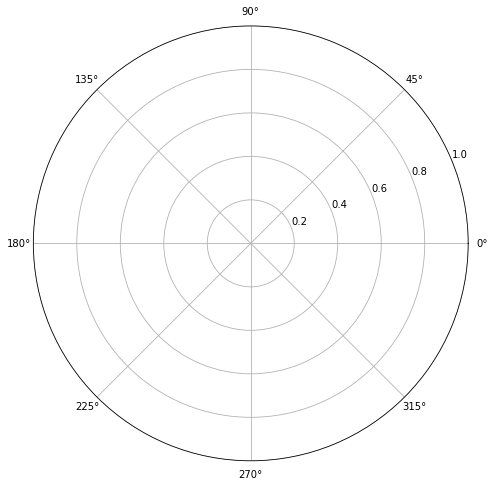

In [12]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'),figsize=(8,8))

In [13]:
_, _, _ = circular_hist(ax, samples/180*np.pi, bins=180)

In [14]:
fig.savefig('angular-hist.png')

In [15]:
import matplotlib.image as mpimg

In [16]:
img = mpimg.imread('./angular-hist.png')

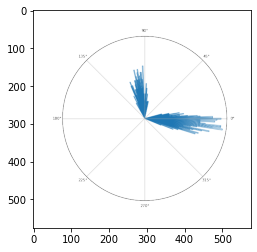

In [17]:
imgplot = plt.imshow(img)

## use WGMM 
here we are using `wgmm` to model the probabilistic distribution of the synthesized angular values.

In [18]:
weights_init = np.array([0.5,0.5])
means_init = np.array([[270.0],[180.0]]) / 180.0 * np.pi
covars_init = np.zeros((2,1,1))
covars_init[0,0,0] = 0.8
covars_init[1,0,0] = 0.8
periods = np.array([2*np.pi])

In [19]:
model = WGMixModel(n_components=2, weights_init=weights_init, means_init=means_init, covars_init=covars_init, periods=periods, 
                   tol=1e-4, reg_covar=1e-6, max_iter=1000)

In [20]:
rng.shuffle(samples)

In [21]:
model.fit(samples[:,np.newaxis] / 180*np.pi)

True

In [22]:
model.means_ / np.pi * 180 # the estimated values, note that the ground-truth values are set to 355 and 100 degrees

array([[355.13560655],
       [ 99.36977191]])

In [23]:
model.weights_ # this value is close enough to the ground truth

array([0.7, 0.3])

In [24]:
model.covars_

array([[[0.01508095]],

       [[0.01955507]]])

## visualize the parameters estimated by `WGMM`

In [25]:
theta = np.array([i for i in range(360)]) / 180 *np.pi

In [26]:
pdf_vals = model.pdf(theta[:,np.newaxis])

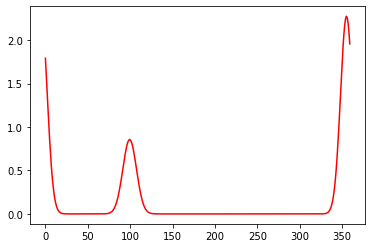

In [27]:
plt.plot(theta/np.pi*180, pdf_vals, 'r')

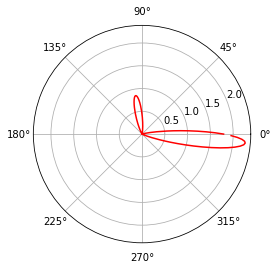

In [28]:
plt.polar(theta, pdf_vals, 'r')